### AIRBNB NASHVILLE DATA ANALYSIS AND VISUALIZATION STEP BY STEP ###

The objective of this notebook is to analyze how is the rental real estate market inside the Airbnb app

#### Datalink : http://insideairbnb.com/get-the-data

Detailed Listings data: <br>
http://data.insideairbnb.com/united-states/tn/nashville/2022-03-20/data/listings.csv.gz

Detailed Calendar Data: <br>
http://data.insideairbnb.com/united-states/tn/nashville/2022-03-20/data/calendar.csv.gz 

Detailed Review Data: <br>
http://data.insideairbnb.com/united-states/tn/nashville/2022-03-20/data/reviews.csv.gz 

Summary information and metrics for listings in Nashville (good for visualisations): <br>
http://data.insideairbnb.com/united-states/tn/nashville/2022-03-20/visualisations/listings.csv

Summary Review data and Listing ID (to facilitate time based analytics and visualisations linked to a listing): <br>
http://data.insideairbnb.com/united-states/tn/nashville/2022-03-20/visualisations/reviews.csv 

Neighbourhood list for geo filter. Sourced from city or open source GIS files: <br>
http://data.insideairbnb.com/united-states/tn/nashville/2022-03-20/visualisations/neighbourhoods.csv 

GeoJSON file of neighbourhoods of the city: <br>
http://data.insideairbnb.com/united-states/tn/nashville/2022-03-20/visualisations/neighbourhoods.geojson 


#### IMPORTING LIBRARIES AND PACKAGES

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# maps
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap

#to make the plotly graphs
import plotly.graph_objs as go
import chart_studio.plotly as py
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

#text mining
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud

#### CHECKING DOWNLOADS FILES IN DIRECTORY 

In [2]:
print(os.listdir("/home/dm/Desktop/airbnb/input"))

['reviews.csv', 'neighbourhoods.csv', 'listings_details.csv', 'calendar.csv', 'neighbourhoods.geojson', 'review2.csv', 'polarity_values_reviews.csv']


#### LINKS VARIABLES FILES AND CONVERT THEM INTO DATAFRAME USING PANDAS LIBRARY


In [3]:
listings_details = pd.read_csv("/home/dm/Desktop/airbnb/input/listings_details.csv")
listings_details = pd.DataFrame(listings_details)

calendar = pd.read_csv("/home/dm/Desktop/airbnb/input/calendar.csv")
calendar = pd.DataFrame(calendar)

neighbourhoods = pd.read_csv("/home/dm/Desktop/airbnb/input/neighbourhoods.csv")
neighbourhoods = pd.DataFrame(neighbourhoods)

reviews = pd.read_csv("/home/dm/Desktop/airbnb/input/reviews.csv")
reviews = pd.DataFrame(reviews)

review2 = pd.read_csv("/home/dm/Desktop/airbnb/input/review2.csv")
review2 = pd.DataFrame(reviews)

#### CHECKING COLUMNS 

In [4]:
listings_details.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

#### BEGIN THE TREATMENT OF NULL VALUES

In [6]:
listings_details.isnull().sum().sum() 

46794

In [7]:
# Null values in listings_details

listings_details.isnull().sum()[listings_details.isnull().sum() > 0] 


description                       46
neighborhood_overview           1911
host_location                     10
host_about                      2091
host_response_time               619
host_response_rate               619
host_acceptance_rate             497
host_neighbourhood              2373
neighbourhood                   1911
neighbourhood_group_cleansed    6799
bathrooms                       6799
bathrooms_text                     4
bedrooms                         321
beds                              41
minimum_minimum_nights             1
maximum_minimum_nights             1
minimum_maximum_nights             1
maximum_maximum_nights             1
minimum_nights_avg_ntm             1
maximum_nights_avg_ntm             1
calendar_updated                6799
first_review                     908
last_review                      908
review_scores_rating             908
review_scores_accuracy           919
review_scores_cleanliness        919
review_scores_checkin            920
r

In [7]:
# Percentage of null values in listings_details

listings_details.isnull().sum()[listings_details.isnull().sum() > 0]/listings_details.shape[0]*100 

description                       0.676570
neighborhood_overview            28.107075
host_location                     0.147080
host_about                       30.754523
host_response_time                9.104280
host_response_rate                9.104280
host_acceptance_rate              7.309899
host_neighbourhood               34.902191
neighbourhood                    28.107075
neighbourhood_group_cleansed    100.000000
bathrooms                       100.000000
bathrooms_text                    0.058832
bedrooms                          4.721283
beds                              0.603030
minimum_minimum_nights            0.014708
maximum_minimum_nights            0.014708
minimum_maximum_nights            0.014708
maximum_maximum_nights            0.014708
minimum_nights_avg_ntm            0.014708
maximum_nights_avg_ntm            0.014708
calendar_updated                100.000000
first_review                     13.354905
last_review                      13.354905
review_scor

##### REMOVING NULL VALUES PLUS THAN 80% OF THE DATA, SAVE THIS FUNTION FOR A FUTURE, U WILL NEED IN NEXT DATA ANALYSIS JOBS :)

In [8]:

def eliminar_columnas(df):
"""
Remove columns in dataframe whit null values more than 80%, u can change the value df.shape[0]*0.8 to change the percentage.
remember inplace=True to aply the changes in the original dataframe.
"""

    for col in df.columns:
        if df[col].isnull().sum() > df.shape[0]*0.8:
            df.drop(col, axis=1, inplace=True)
    return df


eliminar_columnas(listings_details)
eliminar_columnas(calendar)
eliminar_columnas(neighbourhoods)
eliminar_columnas(reviews)
eliminar_columnas(reviews)


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,6422,1927,2009-04-30,14100,Melissa,I can't say enough about how wonderful it was ...
1,6422,3867,2009-06-11,17413,Raquel,Michelle and Collier's home is wonderful! They...
2,6422,4159,2009-06-17,20253,Ulrike,I spent one night at Michele's home and felt j...
3,6422,5724,2009-07-18,22544,Phil,Michele and Collier are two of the loveliest p...
4,6422,11891,2009-09-29,33409,Claire,We had the most lovely time staying with Miche...
...,...,...,...,...,...,...
415079,578352515187036769,585443355907226000,2022-03-18,439418241,Sean,Great communicator. Great Host. Close to every...
415080,579080729746540168,586259968944174013,2022-03-19,165475856,Carlos,The house was great very nice and clean.
415081,579246749462338110,585443160650045205,2022-03-18,117194076,Austin,"Location, location, location! This property is..."
415082,579510477958268252,582543243980031914,2022-03-14,11001577,Jeanine,Alex was a great host very easy to communicate...


In [9]:
# Null values in listings_details

listings_details.isnull().sum()[listings_details.isnull().sum() > 0]/listings_details.shape[0]*100

description                     0.676570
neighborhood_overview          28.107075
host_location                   0.147080
host_about                     30.754523
host_response_time              9.104280
host_response_rate              9.104280
host_acceptance_rate            7.309899
host_neighbourhood             34.902191
neighbourhood                  28.107075
bathrooms_text                  0.058832
bedrooms                        4.721283
beds                            0.603030
minimum_minimum_nights          0.014708
maximum_minimum_nights          0.014708
minimum_maximum_nights          0.014708
maximum_maximum_nights          0.014708
minimum_nights_avg_ntm          0.014708
maximum_nights_avg_ntm          0.014708
first_review                   13.354905
last_review                    13.354905
review_scores_rating           13.354905
review_scores_accuracy         13.516694
review_scores_cleanliness      13.516694
review_scores_checkin          13.531402
review_scores_co

In [10]:
calendar.isnull().sum()[calendar.isnull().sum() > 0]/calendar.shape[0]*100 

minimum_nights    0.000605
maximum_nights    0.000605
dtype: float64

In [11]:
neighbourhoods.isnull().sum()[neighbourhoods.isnull().sum() > 0]/neighbourhoods.shape[0]*100

Series([], dtype: float64)

In [12]:
reviews.isnull().sum()[reviews.isnull().sum() > 0]/reviews.shape[0]*100

reviewer_name    0.000241
comments         0.032524
dtype: float64

In [13]:
reviews.isnull().sum()[reviews.isnull().sum() > 0]/reviews.shape[0]*100

reviewer_name    0.000241
comments         0.032524
dtype: float64

##### This funtion calculate the median or the mode in a dataframe to repair nulles values


In [14]:

def repair_null(df):
    
    """ 
    Repair null values in dataframe using mode if the column is categorical or mean if the column is numerical.
    
    """
    
    
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            df[col].fillna(df[col].mean(), inplace=True)
    return df

# Repair null values in dataframes
repair_null(listings_details)
repair_null(calendar)
repair_null(neighbourhoods)
repair_null(reviews)
repair_null(reviews)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,6422,1927,2009-04-30,14100,Melissa,I can't say enough about how wonderful it was ...
1,6422,3867,2009-06-11,17413,Raquel,Michelle and Collier's home is wonderful! They...
2,6422,4159,2009-06-17,20253,Ulrike,I spent one night at Michele's home and felt j...
3,6422,5724,2009-07-18,22544,Phil,Michele and Collier are two of the loveliest p...
4,6422,11891,2009-09-29,33409,Claire,We had the most lovely time staying with Miche...
...,...,...,...,...,...,...
415079,578352515187036769,585443355907226000,2022-03-18,439418241,Sean,Great communicator. Great Host. Close to every...
415080,579080729746540168,586259968944174013,2022-03-19,165475856,Carlos,The house was great very nice and clean.
415081,579246749462338110,585443160650045205,2022-03-18,117194076,Austin,"Location, location, location! This property is..."
415082,579510477958268252,582543243980031914,2022-03-14,11001577,Jeanine,Alex was a great host very easy to communicate...


In [15]:
listings_details.isnull().sum() #Checking again to be sure

id                                              0
listing_url                                     0
scrape_id                                       0
last_scraped                                    0
name                                            0
                                               ..
calculated_host_listings_count                  0
calculated_host_listings_count_entire_homes     0
calculated_host_listings_count_private_rooms    0
calculated_host_listings_count_shared_rooms     0
reviews_per_month                               0
Length: 70, dtype: int64

##### STARTING EDA (EXPLORATORY DATA ANALYSIS)

Property types in Nashville TN


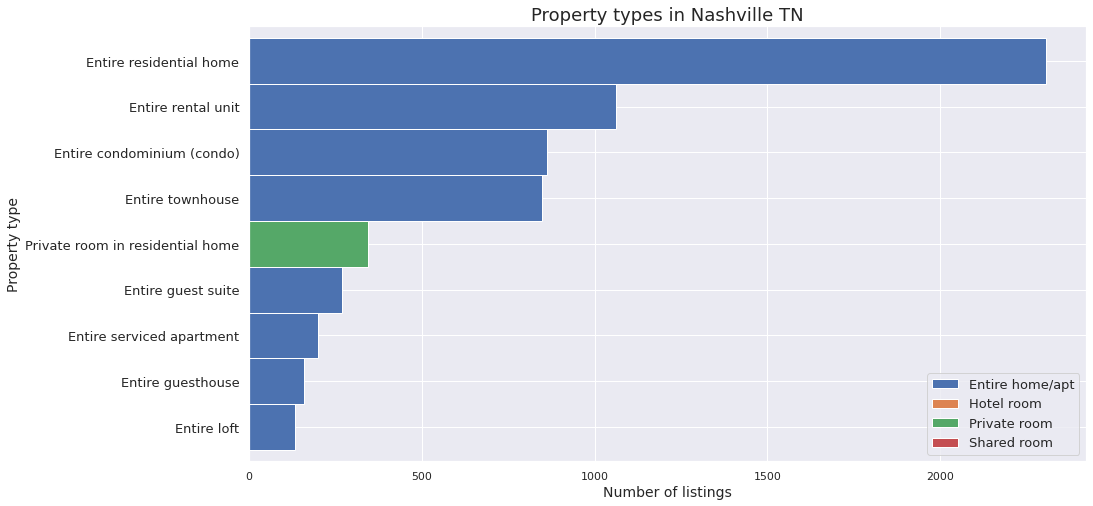

In [17]:
#Property type vs number of listings

prop = listings_details.groupby(['property_type','room_type']).room_type.count() #Counting the number of rooms by property type
prop = prop.unstack() #Unstacking the dataframe
prop['total'] = prop.iloc[:,0:3].sum(axis = 1) #Summing the rooms by property type
prop = prop.sort_values(by=['total']) #Sorting the dataframe by total rooms
prop = prop[prop['total']>=100] #Selecting the properties counting more than 100 
prop = prop.drop(columns=['total']) #Dropping the total column

prop.plot(kind='barh',stacked=True, linewidth = 1, grid=True, figsize=(15,8), width=1) #Plotting the dataframe
plt.title('Property types in Nashville TN', fontsize=18) #Setting the title
plt.xlabel('Number of listings', fontsize=14) #Setting the xlabel
plt.ylabel("Property type", fontsize=14) #Setting the ylabel
plt.legend(loc = 4,prop = {"size" : 13}) #Setting the legend
plt.rc('ytick', labelsize=13)  #Setting the fontsize of the ytick labels
print ("Property types in Nashville TN") #Printing the title
plt.show() #Showing the plot

The most common number of people in a room is 4, asuming a family renting


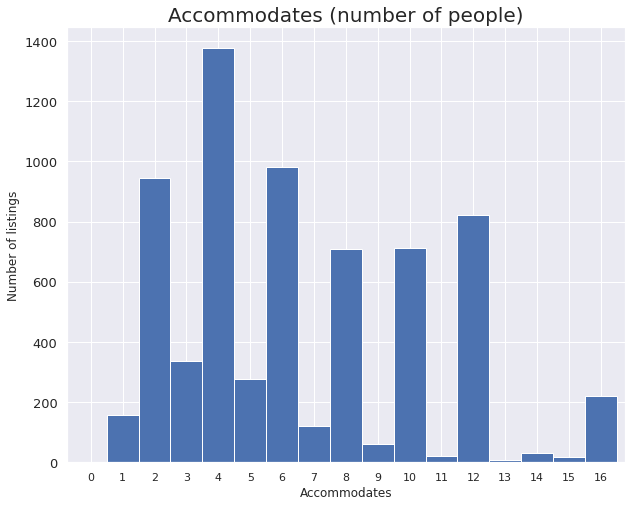

In [18]:
feq=listings_details['accommodates'].value_counts().sort_index() #Value counts of accommodates
feq.plot.bar(figsize=(10, 8), color='b', width=1, rot=0) #Configuring the plot
plt.title("Accommodates (number of people)", fontsize=20) #Setting the title
plt.ylabel('Number of listings', fontsize=12) #Setting the ylabel
plt.xlabel('Accommodates', fontsize=12) #Setting the xlabel
print("The most common number of people in a room is 4, asuming a family renting") #Printing the title
plt.show() #Showing the plot

##### MAPING THE PROPERTIES 

In [16]:
lats_nash = listings_details['latitude'].tolist() #latitude of the listings
lons_nash = listings_details['longitude'].tolist() #longitude of the listings 
locations = list(zip(lats_nash, lons_nash)) #zip the latitude and longitude

map1 = folium.Map(location=[ 36.36133, -86.72463], zoom_start=11) #create a map
FastMarkerCluster(data=locations).add_to(map1) #add the locations to the map
map1 #show the map


##### ORDERING ROOMS TYPES AND LISTING TYPES

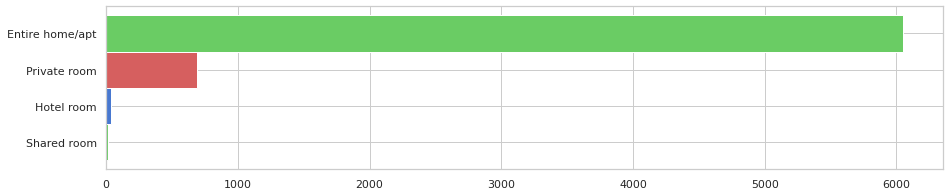

In [20]:
freq = listings_details['room_type']. value_counts().sort_values(ascending=True) #room type frequency
freq.plot.barh(figsize=(15, 3), width=1, color = ["g","b","r"]) #configure the plot
plt.show() #show the plot

In [21]:
listings_details.property_type.unique() #unique property types

array(['Entire residential home', 'Private room in residential home',
       'Entire guesthouse', 'Entire cottage', 'Entire cabin',
       'Entire rental unit', 'Entire guest suite', 'Private room',
       'Farm stay', 'Private room in cottage',
       'Entire condominium (condo)', 'Entire chalet', 'Entire loft',
       'Entire townhouse', 'Shared room in residential home',
       'Private room in bungalow', 'Private room in guest suite',
       'Entire bungalow', 'Private room in rental unit', 'Room in hostel',
       'Private room in condominium (condo)', 'Entire villa', 'Barn',
       'Room in aparthotel', 'Tiny house', 'Entire serviced apartment',
       'Private room in bed and breakfast', 'Earth house',
       'Private room in townhouse', 'Camper/RV', 'Shared room in hostel',
       'Private room in nature lodge', 'Private room in hostel',
       'Shared room in condominium (condo)', 'Private room in resort',
       'Room in boutique hotel', 'Entire place', 'Shared room in loft',

##### Private rooms in the listings, the objective is to see is a not enterprising person is doing business in the city

In [22]:

private = listings_details[listings_details['property_type'] == 'Private room'] #selecting the private rooms
host_private = private.groupby(["host_id",'host_name', 'neighbourhood']).size().reset_index(name='private_rooms').sort_values(by=['private_rooms'], ascending=False)
host_private.head()

,host_id,host_name,neighbourhood,private_rooms
0,26863205,Doug,"Nashville, Tennessee, United States",9


##### For example, Doug hosts have 10 private rooms in listings, lets see him data

In [23]:
Doug = private[private['host_id']== 26863205]
Doug = Doug[['name','host_id', 'host_name', 'latitude', 'longitude']]
Doug.index.name = "listing_id"
Doug

,name,host_id,host_name,latitude,longitude
listing_id,,,,,
3491,The Mural House,26863205,Doug,36.21531,-86.73119
4666,Micro-Suite (30 Day Minimum) A Neat Spot!,26863205,Doug,36.21566,-86.73157
4667,A Cool Stay in Hot Nashville,26863205,Doug,36.21345,-86.73118
4678,Perfect Spot Near Downtown!,26863205,Doug,36.21385,-86.72976
4684,Urban Charm 5.5 miles to Downtown!,26863205,Doug,36.21422,-86.73166
4720,Southern Comfort in the Heart of Nashville!,26863205,Doug,36.21384,-86.73161
4763,Hostel Nashville-Private Room,26863205,Doug,36.21492,-86.73025
4824,Check out this unique extended stay in Nashville!,26863205,Doug,36.21530,-86.73109
4858,Everything You Need In This Private Room!,26863205,Doug,36.21419,-86.73115


Text(0.5, 1.0, "Doug's listings")

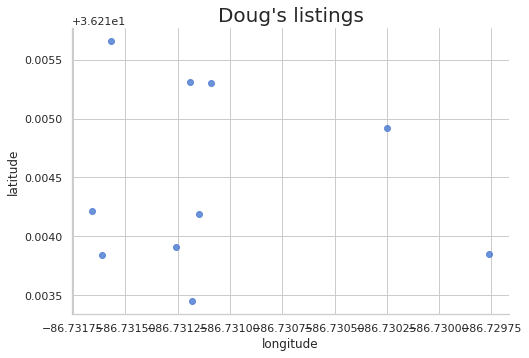

In [24]:
sns.set(style="whitegrid", palette="muted")
sns.lmplot(x="longitude", y="latitude", data=Doug, fit_reg=False, hue="host_id", height=5, aspect=1.5, legend=False)
plt.title("Doug's listings", fontsize=20)

In [24]:
lats_doug = Doug['latitude'].tolist()
lons_doug = Doug['longitude'].tolist()
locations = list(zip(lats_doug, lons_doug))

map1 = folium.Map(location=[ 36.21422, -86.73166], zoom_start=15 )
FastMarkerCluster(data=locations).add_to(map1)
map1

In [25]:
#normalize in listings_details the columns 'price'

listings_details['price'] = listings_details['price'].str.replace('$','')
listings_details['price'] = listings_details['price'].str.replace(',','')

#erase two zeros in the price column at right side 

listings_details['price'] = listings_details['price'].str.replace('.00','')
listings_details['price'].value_counts()


        208
150      69
103      49
99       45
250      43
       ... 
1888      1
540       1
709       1
1256      1
1303      1
Name: price, Length: 847, dtype: int64

In [26]:
listings_details.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 

In [27]:
#!pip install langdetect


In [28]:
reviews.columns

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')

In [29]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /home/dm/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [30]:
reviewsDF = reviews.copy()

In [31]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

reviewsDF['polarity_value']="Default"
reviewsDF['neg']=0.0
reviewsDF['pos']=0.0
reviewsDF['neu']=0.0
reviewsDF['compound']=0.0
for index,row in reviewsDF.iterrows():
    ss = sid.polarity_scores(row['comments'])
    reviewsDF.at[index,'polarity_value'] = ss
    reviewsDF.at[index,'neg'] = ss['neg']
    reviewsDF.at[index,'pos'] = ss['pos']
    reviewsDF.at[index,'neu']= ss['neu']
    reviewsDF.at[index,'compound'] = ss['compound']
reviewsDF.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,polarity_value,neg,pos,neu,compound
0,6422,1927,2009-04-30,14100,Melissa,I can't say enough about how wonderful it was ...,"{'neg': 0.008, 'neu': 0.659, 'pos': 0.333, 'co...",0.008,0.333,0.659,0.9942
1,6422,3867,2009-06-11,17413,Raquel,Michelle and Collier's home is wonderful! They...,"{'neg': 0.0, 'neu': 0.601, 'pos': 0.399, 'comp...",0.000,0.399,0.601,0.9953
2,6422,4159,2009-06-17,20253,Ulrike,I spent one night at Michele's home and felt j...,"{'neg': 0.0, 'neu': 0.687, 'pos': 0.313, 'comp...",0.000,0.313,0.687,0.9763
3,6422,5724,2009-07-18,22544,Phil,Michele and Collier are two of the loveliest p...,"{'neg': 0.018, 'neu': 0.78, 'pos': 0.202, 'com...",0.018,0.202,0.780,0.9680
4,6422,11891,2009-09-29,33409,Claire,We had the most lovely time staying with Miche...,"{'neg': 0.04, 'neu': 0.692, 'pos': 0.268, 'com...",0.040,0.268,0.692,0.9805


In [32]:
reviewsDF.to_csv('/home/dm/Desktop/airbnb/input/polarity_values_reviews.csv')

In [33]:

#17 minutos 
from langdetect import detect

def detect_lang(sente):
    sente=str(sente)
    try:
        return detect(sente)
    except:
        return "None"

for index,row in reviewsDF.iterrows():
    lang=detect_lang(row['comments'])
    reviewsDF.at[index,'language'] = lang
#     print(lang)
    
#taking rows whose language is English
EngReviewsDF=reviewsDF[reviewsDF.language=='en']

EngReviewsDF.head(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments,polarity_value,neg,pos,neu,compound,language
0,6422,1927,2009-04-30,14100,Melissa,I can't say enough about how wonderful it was ...,"{'neg': 0.008, 'neu': 0.659, 'pos': 0.333, 'co...",0.008,0.333,0.659,0.9942,en
1,6422,3867,2009-06-11,17413,Raquel,Michelle and Collier's home is wonderful! They...,"{'neg': 0.0, 'neu': 0.601, 'pos': 0.399, 'comp...",0.000,0.399,0.601,0.9953,en


In [34]:
polarDF=EngReviewsDF[['pos']]
polarDF=polarDF.groupby(pd.cut(polarDF["pos"], np.arange(0, 1.1, 0.1))).count()
polarDF=polarDF.rename(columns={'pos':'count_of_Comments'})
polarDF=polarDF.reset_index()
polarDF=polarDF.rename(columns={'pos':'range_i'})
for i,r in polarDF.iterrows():
    polarDF.at[i,'RANGE'] = float(str(r['range_i'])[1:4].replace(',',''))
    polarDF.at[i,'Sentiment'] = 'positive'
del polarDF['range_i']
polarDF.head()

,count_of_Comments,RANGE,Sentiment
0,6403,0.0,positive
1,43291,0.1,positive
2,98838,0.2,positive
3,102297,0.3,positive
4,68839,0.4,positive


In [35]:
polarDFneg=EngReviewsDF[['neg']]
polarDFneg=polarDFneg.groupby(pd.cut(polarDFneg["neg"], np.arange(0, 1.1, 0.1))).count()
polarDFneg=polarDFneg.rename(columns={'neg':'count_of_Comments'})
polarDFneg=polarDFneg.reset_index()
polarDFneg=polarDFneg.rename(columns={'neg':'range_i'})
for i,r in polarDFneg.iterrows():
    polarDFneg.at[i,'RANGE'] = float(str(r['range_i'])[1:4].replace(',',''))
    polarDFneg.at[i,'Sentiment'] = 'negative'
del polarDFneg['range_i']
for i,r in polarDFneg.iterrows():
    polarDF=polarDF.append(pd.Series([r[0],r[1],r[2]],index=['count_of_Comments','RANGE','Sentiment']),ignore_index=True)
    
polarDFneg.head()

,count_of_Comments,RANGE,Sentiment
0,61646,0.0,negative
1,7063,0.1,negative
2,1040,0.2,negative
3,280,0.3,negative
4,123,0.4,negative


In [36]:
polarDFneut=EngReviewsDF[['neu']]
polarDFneut=polarDFneut.groupby(pd.cut(polarDFneut["neu"], np.arange(0, 1.0, 0.1))).count()
polarDFneut=polarDFneut.rename(columns={'neu':'count_of_Comments'})
polarDFneut=polarDFneut.reset_index()
polarDFneut=polarDFneut.rename(columns={'neu':'range_i'})
for i,r in polarDFneut.iterrows():
    polarDFneut.at[i,'RANGE'] = float(str(r['range_i'])[1:4].replace(',',''))
    polarDFneut.at[i,'Sentiment'] = 'neutral' 
del polarDFneut['range_i']

for i,r in polarDFneut.iterrows():
    polarDF=polarDF.append(pd.Series([r[0],r[1],r[2]],index=['count_of_Comments','RANGE','Sentiment']),ignore_index=True)
    
polarDFneut.head()

,count_of_Comments,RANGE,Sentiment
0,239,0.0,neutral
1,8634,0.1,neutral
2,12149,0.2,neutral
3,21428,0.3,neutral
4,43335,0.4,neutral


/home/dm/.local/lib/python3.8/site-packages/seaborn/categorical.py:3717: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



<Figure size 720x720 with 0 Axes>

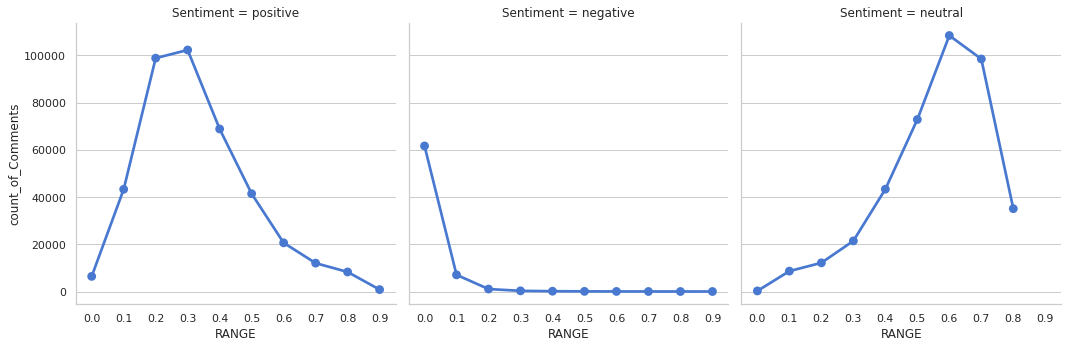

In [37]:

plt.figure(figsize=(10,10))
sns.factorplot(data=polarDF, x="RANGE", y="count_of_Comments",col="Sentiment") 


In [60]:
#add to polardf column 'prices' 

polarDF['prices']=listings_details['price']

<Figure size 720x720 with 0 Axes>

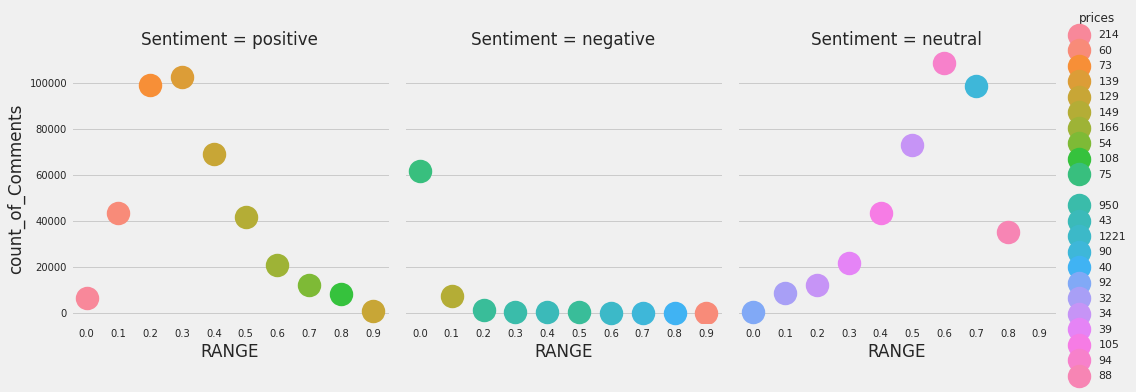

In [65]:
plt.figure(figsize=(10,10))
sns.factorplot(data=polarDF, x="RANGE", y="count_of_Comments",hue="prices",col="Sentiment")

Text(0, 0.5, 'Number of reviews')

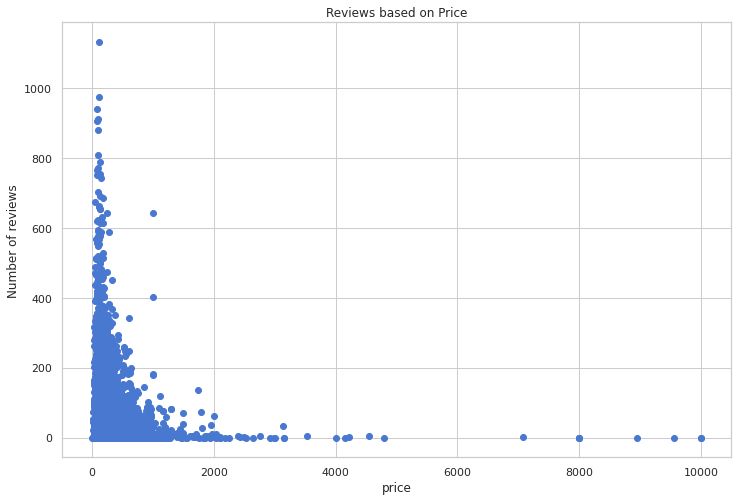

In [38]:
inputDF = pd.read_csv('/home/dm/Desktop/airbnb/input/listings_details.csv')
inputDF=inputDF[['number_of_reviews','price','review_scores_rating']]

# replacing NaN values with 0
inputDF.fillna(0, inplace=True)

#Extracting prices from the table
price = inputDF['price']
prices=[]

#clean the data to make it float
for p in price:
    p=float(p[1:].replace(',',''))
    prices.append(p)

#replace the price column with the new column
inputDF['price']=prices

price_review = inputDF[['number_of_reviews', 'price']].sort_values(by = 'price')

price_review.plot(x = 'price', 
                  y = 'number_of_reviews', 
                  style = 'o',
                  figsize =(12,8),
                  legend = False,
                  title = 'Reviews based on Price')

plt.xlabel("price")
plt.ylabel("Number of reviews")

In [39]:


#take out empty comments (530)
EngReviewsDF = EngReviewsDF[EngReviewsDF['comments'].notnull()]

#remove numbers
EngReviewsDF['comments'] = EngReviewsDF['comments'].str.replace('\d+', '') 
#all to lowercase
EngReviewsDF['comments'] = EngReviewsDF['comments'].str.lower()
#remove windows new line
EngReviewsDF['comments'] = EngReviewsDF['comments'].str.replace('\r\n', "")
#remove stopwords (from nltk library)
stop_english = stopwords.words("english")
EngReviewsDF['comments'] = EngReviewsDF['comments'].apply(lambda x: " ".join([i for i in x.split() 
                                                      if i not in (stop_english)]))
# remove punctuation
EngReviewsDF['comments'] = EngReviewsDF['comments'].str.replace('[^\w\s]'," ")
# replace x spaces by one space
EngReviewsDF['comments'] = EngReviewsDF['comments'].str.replace('\s+', ' ')

EngReviewsDF.comments.values[2] #print same comments again

'spent one night michele s home felt wonderful right home beautiful place michele family extraordinarily welcoming open minded warm generous would use better words describe english better looking nice place stay nashville want meet nicest people place be '

In [40]:
texts = EngReviewsDF.comments.tolist()

vec = CountVectorizer().fit(texts)
bag_of_words = vec.transform(texts)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

cvec_df = pd.DataFrame.from_records(words_freq, columns= ['words', 'counts']).sort_values(by="counts", ascending=False)
cvec_df.head(10)

,words,counts
55,great,271220
81,place,215226
4,stay,208713
306,location,142691
7,nashville,138394
310,clean,126568
74,would,106662
90,br,95723
29,house,86660
432,perfect,83312


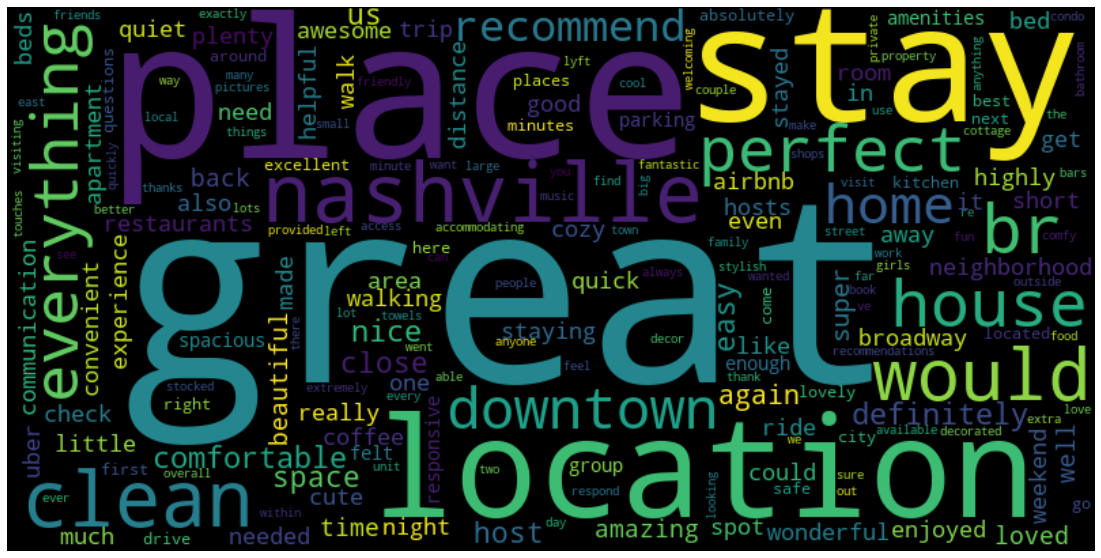

In [41]:
cvec_dict = dict(zip(cvec_df.words, cvec_df.counts))

wordcloud = WordCloud(width=800, height=400)
wordcloud.generate_from_frequencies(frequencies=cvec_dict)
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

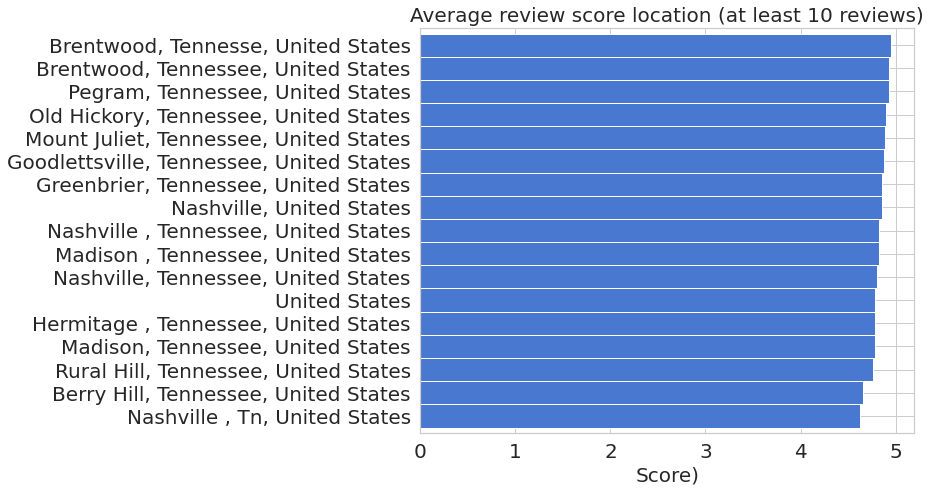

In [42]:
fig = plt.figure(figsize=(20,7))
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

ax1 = fig.add_subplot(121)
feq = listings_details[listings_details['number_of_reviews']>=10]
feq1 = feq.groupby('neighbourhood')['review_scores_location'].mean().sort_values(ascending=True)
ax1=feq1.plot.barh(color='b', width=1)
plt.title("Average review score location (at least 10 reviews)", fontsize=20)
plt.xlabel('Score)', fontsize=20)
plt.ylabel("")



plt.tight_layout()
plt.show()

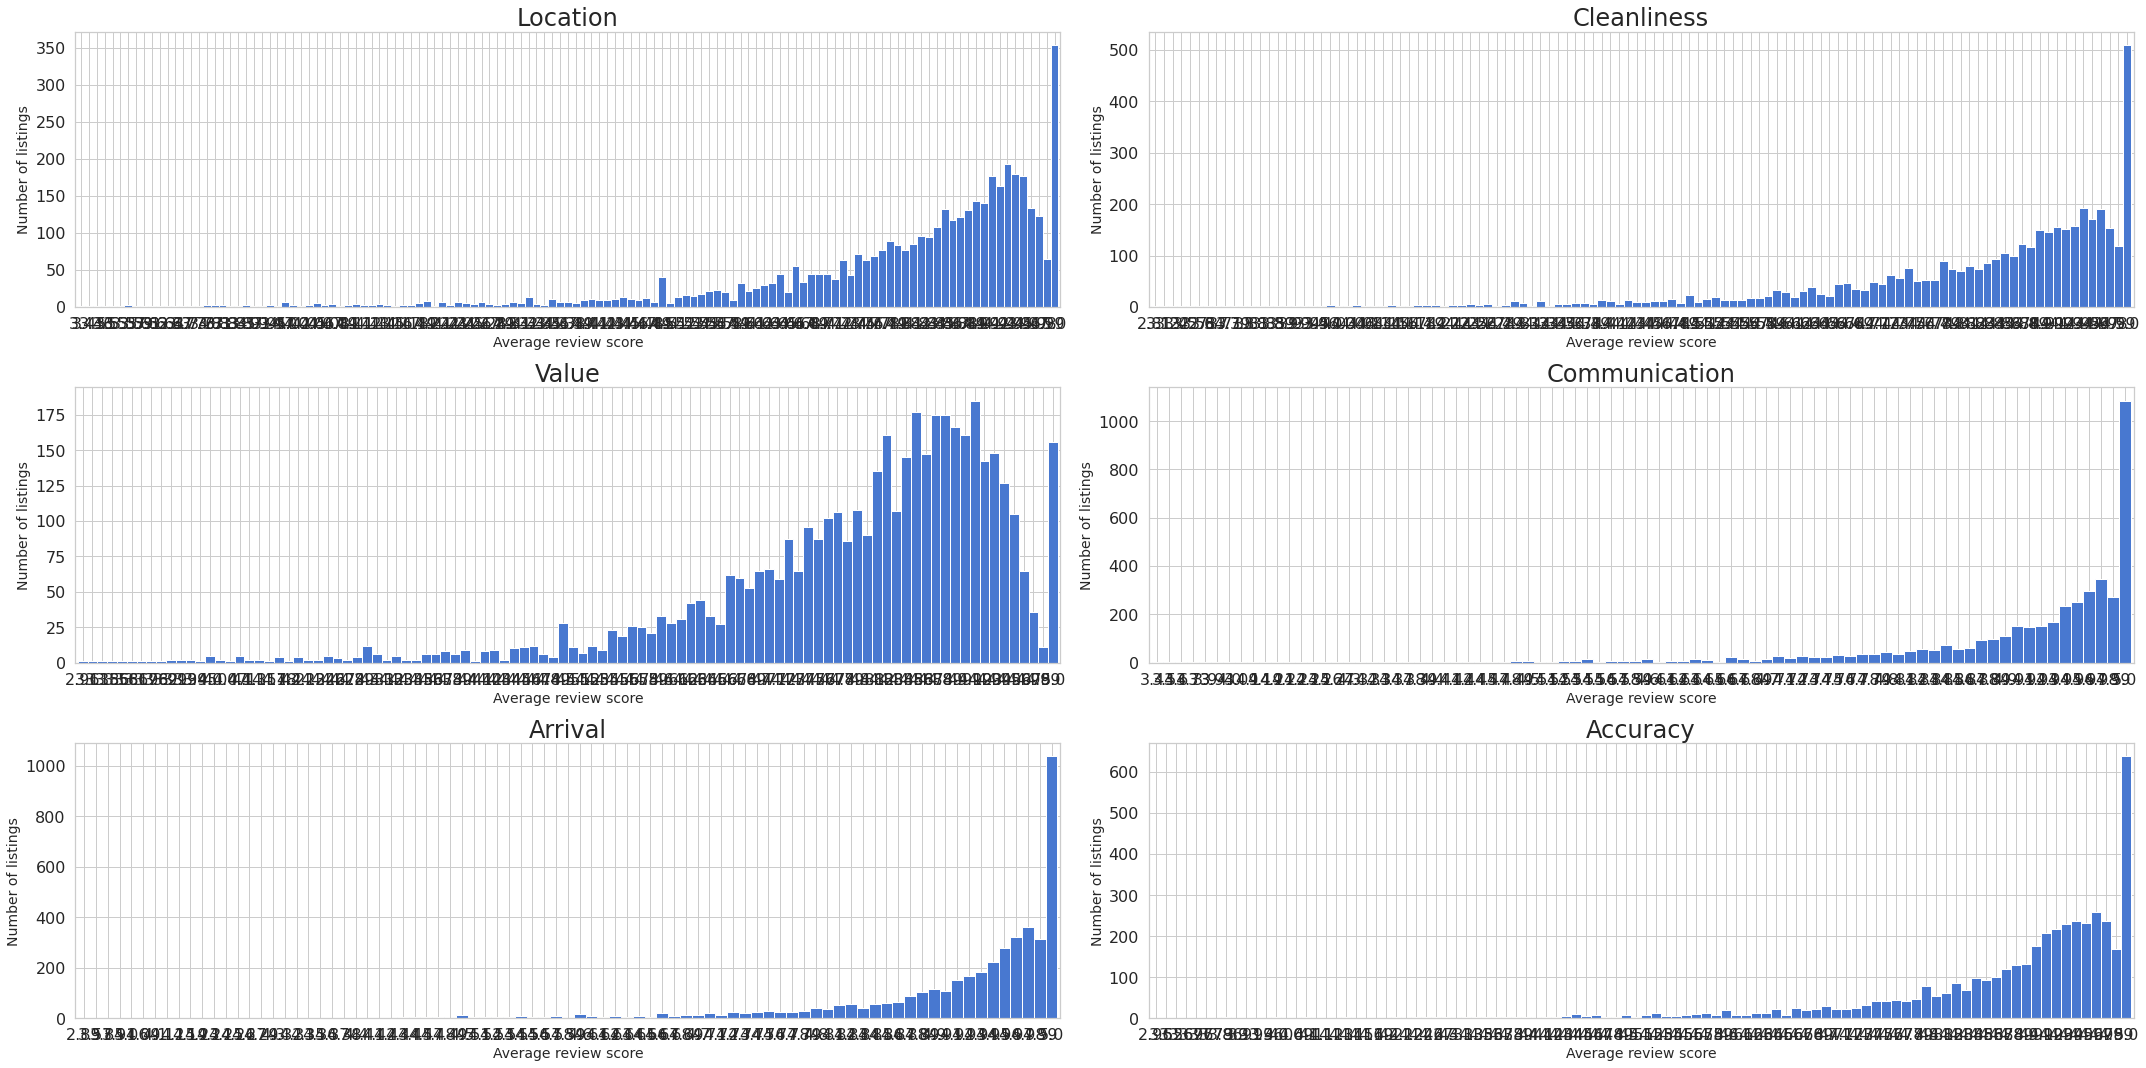

In [43]:
listings10 = listings_details[listings_details['number_of_reviews']>=10]

fig = plt.figure(figsize=(30,15))
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)

ax1 = fig.add_subplot(321)
feq=listings10['review_scores_location'].value_counts().sort_index()
ax1=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Location", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax2 = fig.add_subplot(322)
feq=listings10['review_scores_cleanliness'].value_counts().sort_index()
ax2=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Cleanliness", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax3 = fig.add_subplot(323)
feq=listings10['review_scores_value'].value_counts().sort_index()
ax3=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Value", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax4 = fig.add_subplot(324)
feq=listings10['review_scores_communication'].value_counts().sort_index()
ax4=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Communication", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax5 = fig.add_subplot(325)
feq=listings10['review_scores_checkin'].value_counts().sort_index()
ax5=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Arrival", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax6 = fig.add_subplot(326)
feq=listings10['review_scores_accuracy'].value_counts().sort_index()
ax6=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Accuracy", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

plt.tight_layout()
plt.show()

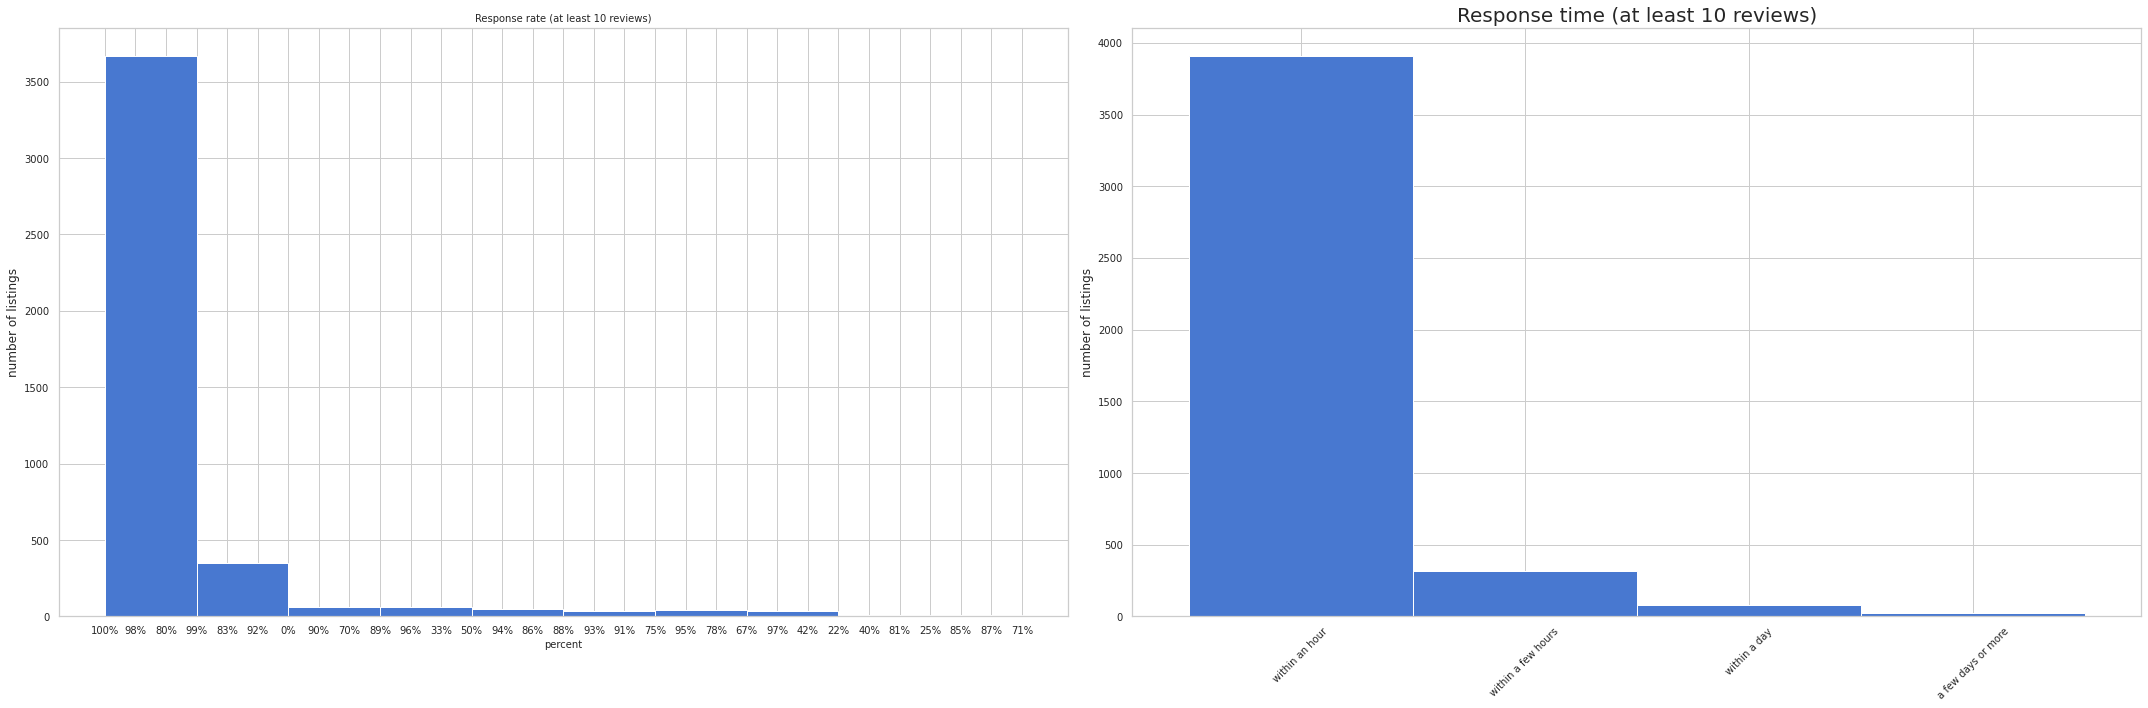

In [44]:
fig = plt.figure(figsize=(30,10))
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

ax1 = fig.add_subplot(121)
feq1 = listings10['host_response_rate'].dropna()
ax1= plt.hist(feq1)
plt.title("Response rate (at least 10 reviews)", fontsize=10)
plt.ylabel("number of listings")
plt.xlabel("percent", fontsize=10)

ax2 = fig.add_subplot(122)
feq2 = listings10['host_response_time'].value_counts()
ax2=feq2.plot.bar(color='b', width=1, rot=45)
plt.title("Response time (at least 10 reviews)", fontsize=20)
plt.ylabel("number of listings")

plt.tight_layout()
plt.show()

In [45]:
listings_details.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 

In [46]:
neighbourhoods.columns

Index(['neighbourhood'], dtype='object')

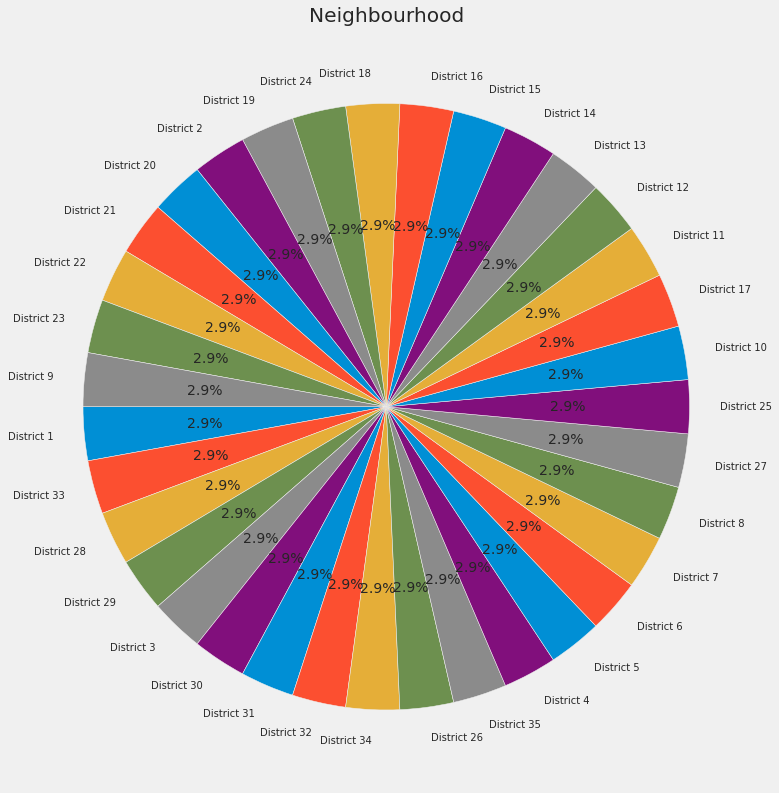

In [47]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(13,13))
plt.title("Neighbourhood")
g = plt.pie(neighbourhoods.neighbourhood.value_counts(), 
labels=neighbourhoods.neighbourhood.value_counts().index,autopct='%1.1f%%', startangle=180)
plt.show()

In [48]:
#add to listings_details dataframe the neighbourhood column from neighbourhoods dataframe

listings_details = listings_details.merge(neighbourhoods, on='neighbourhood', how='left')


In [49]:
listings_details.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

In [51]:
#label encode the listing_details dataframe in a new copy 

listings_details_label = listings_details.copy()

def label_encoder(df):
    le = preprocessing.LabelEncoder()
    df_le = df.copy()
    for col in df_le.columns:
        if df_le[col].dtype == 'object':
            df_le[col] = le.fit_transform(df_le[col])
    return df_le

label_encoder(listings_details_label)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,46607590,3688,20220320051215,0,3646,3870,800,1247,230819613,1038,...,5.000000,5.000000,4.850000,4.930000,0,1,1,0,0,3.580000
1,28916403,1557,20220320051215,0,730,6054,3414,2154,217285315,955,...,4.960000,4.900000,4.920000,4.900000,1,2,0,2,0,1.140000
2,26496915,1373,20220320051215,0,5323,1472,2965,1541,132765119,302,...,4.990000,4.950000,4.900000,4.930000,0,4,4,0,0,2.600000
3,44395269,3374,20220320051215,0,1397,1354,1948,3491,88197167,2927,...,5.000000,5.000000,5.000000,5.000000,1,3,3,0,0,4.390000
4,32341026,1892,20220320051215,0,1132,1260,955,1653,88197167,2927,...,4.990000,4.990000,4.930000,4.980000,1,3,3,0,0,8.070000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6794,585581618267659285,6554,20220320051215,0,2845,431,1958,6506,134126657,319,...,4.895098,4.887935,4.792611,4.772563,1,58,58,0,0,2.316179
6795,585908990326289759,6555,20220320051215,0,3020,4517,1958,6507,263502162,1256,...,4.895098,4.887935,4.792611,4.772563,1,9,9,0,0,2.316179
6796,585927996724919949,6556,20220320051215,0,3022,4518,1958,6508,263502162,1256,...,4.895098,4.887935,4.792611,4.772563,1,9,9,0,0,2.316179
6797,585996401122268935,6558,20220320051215,0,584,3999,1958,2683,368944610,1782,...,4.895098,4.887935,4.792611,4.772563,1,119,119,0,0,2.316179


In [52]:
listings_details_label.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 

In [53]:
"""
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X= pd.get_dummies(listings_details_label.drop(['price'],axis=1),drop_first=True) 
y= listings_details_label['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
test_x = listings_details_label
"""


"\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.metrics import classification_report\n\nX= pd.get_dummies(listings_details_label.drop(['price'],axis=1),drop_first=True) \ny= listings_details_label['price']\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) \ntest_x = listings_details_label\n"

In [54]:
listings_details_label = listings_details_label.drop(["listing_url", "picture_url", "host_url", "host_thumbnail_url","host_picture_url"], axis=1)

In [55]:
listings_details_label.columns

Index(['id', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'host_id', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped', 'number_of_reviews',

In [56]:
#Logistic Regression (continue)
"""
logistic = LogisticRegression(solver='liblinear', max_iter=10)
logistic.fit(X_train, y_train)
predictions_LR= logistic.predict(test_x)

logistic.score(X_train, y_train)
"""


"\nlogistic = LogisticRegression(solver='liblinear', max_iter=10)\nlogistic.fit(X_train, y_train)\npredictions_LR= logistic.predict(test_x)\n\nlogistic.score(X_train, y_train)\n"